## 1. Import Library

In [14]:
# === Library Dasar Python ===
import os
import pickle
import joblib

# === Library Manipulasi Data ===
import numpy as np
import pandas as pd

# === Library Visualisasi ===
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# === Library Scikit-Learn (Preprocessing, Model, Evaluasi, Split Data) ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

# === Library Model Lain (CatBoost) ===
from catboost import CatBoostRegressor, Pool

# === Library Hyperparameter Tuning ===
import optuna

from FeatureExtraction import deteksiPerson, kedalamanCitra, ekstrakMetadataCitra, ubahUkuran, ekstraksiFitur
from pillow_heif import register_heif_opener
register_heif_opener()

## 2. Data Understanding

In [2]:
data = pd.read_csv("../data/DatabaseTinggi.csv")

### 2.1 Mengetahui Ringkasan Statistik dari Data

In [3]:
data.describe(include='all')

,LebarBB,TinggiBB,ID,TitikTengah_x,TitikTengah_y,kedalamanObjek,fl_px,ImageWidth,ImageLength,FocalLength,FocalLengthIn35mmFilm,ApertureValue,BrightnessValue,TinggiAktual
count,34.000000,34.000000,34,34.000000,34.000000,34.000000,34.000000,32.000000,32.000000,34.000000,31.000000,30.000000,2.900000e+01,34.000000
unique,NaN,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,/kaggle/input/datasetraw/bimo3_180.heic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1036.742059,3306.798529,NaN,1555.483676,2765.631618,1.691612,3380.009383,3811.875000,3249.500000,4.728294,23.903226,1.648637,1.481025e+06,168.308824
std,409.419899,1307.510158,NaN,633.266002,1145.531484,0.494034,1671.268292,1913.056662,1459.496953,0.662169,6.062754,0.237002,7.975553e+06,7.813173
min,490.020000,1613.100000,NaN,611.370000,1253.060000,0.213635,360.555128,512.000000,288.000000,3.462000,0.000000,1.356144,-2.810000e+00,156.000000
25%,800.855000,2670.330000,NaN,1164.778750,2244.516250,1.471144,2775.111527,3000.000000,3024.000000,4.200000,25.000000,1.377108,7.900000e-01,161.500000
50%,919.645000,2948.100000,NaN,1508.745000,2454.385000,1.711220,3028.663071,4032.000000,3024.000000,4.655000,26.000000,1.690000,1.654635e+00,167.000000
75%,1136.067500,3437.132500,NaN,1753.002500,2739.138750,1.936388,3348.542227,4624.000000,4000.000000,5.310000,26.000000,1.695994,4.590000e+00,176.375000


### 2.2 Visualisasi Sebaran Data pada Setiap Variabel

In [ ]:
def visualisasiData(df):
    """
    Memvisualisasikan semua kolom numerik dalam sebuah DataFrame.

    Untuk setiap kolom numerik:
    1. Membuat histogram untuk menunjukkan distribusi data.
    2. Membuat box plot untuk mengidentifikasi outlier dan sebaran data.

    Parameter:
    df (pd.DataFrame): DataFrame yang ingin divisualisasikan kolom numeriknya.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns

    if len(numeric_cols) == 0:
        print("Tidak ada kolom numerik dalam DataFrame ini.")
        return

    print(f"Memvisualisasikan {len(numeric_cols)} kolom numerik...")

    for col in numeric_cols:
        plt.figure(figsize=(12, 5))

        # Subplot 1: Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'Histogram dari {col}')
        plt.xlabel(col)
        plt.ylabel('Frekuensi')

        # Subplot 2: Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col], color='lightcoral')
        plt.title(f'Box Plot dari {col}')
        plt.ylabel(col)

        plt.tight_layout()
        plt.show()
visualisasiData(data)

## 3. Data Preparation

### 3.1 Splitting Data

In [5]:
data = data.dropna()
data.loc[data['kedalamanObjek'] < 1, 'kedalamanObjek'] = 1.5
data['rasioDepth_flpx'] = data['kedalamanObjek']/data['fl_px']
data['rasioTBB_flpx'] = data['TinggiBB']/data['fl_px']
data['rasioTBB_Width'] = data['TinggiBB']/(data['ImageWidth'])
data['rasioTBB_Depth'] = data['TinggiBB']/data['kedalamanObjek']
data['rasioFF'] = data['FocalLength']/data['FocalLengthIn35mmFilm']

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def korelasiVIFTarget(df, target='TinggiAktual'):
    """
    Menghitung korelasi Pearson terhadap kolom target dan VIF antar fitur numerik.

    Parameter:
        df (pd.DataFrame): DataFrame input.
        target (str): Nama kolom target, default 'TinggiAktual'.

    Return:
        tuple:
            - pd.Series: Korelasi terhadap kolom target (tanpa target itu sendiri),
                         diurutkan berdasarkan nilai absolut.
            - pd.DataFrame: DataFrame VIF untuk fitur numerik (tanpa kolom target).
    """
    if target not in df.columns:
        raise ValueError(f"DataFrame tidak memiliki kolom target '{target}'.")

    # Pilih hanya kolom numerik
    kolom_numerik = df.select_dtypes(include='number')

    # Korelasi Pearson
    korelasi = kolom_numerik.corr()[target].drop(labels=[target])
    korelasi = korelasi.reindex(korelasi.abs().sort_values(ascending=False).index)

    return korelasi

korelasi = korelasiVIFTarget(data)

In [6]:
print("=======================Korelasi=====================")
print(korelasi)

=======================Korelasi=====================
LebarBB                 -0.414344
rasioDepth_flpx          0.343556
rasioTBB_Depth          -0.329629
fl_px                   -0.325216
TinggiBB                -0.301317
kedalamanObjek           0.282233
BrightnessValue          0.240555
TitikTengah_x           -0.231439
rasioFF                  0.224387
rasioTBB_flpx            0.214879
FocalLengthIn35mmFilm   -0.192858
TitikTengah_y           -0.139493
rasioTBB_Width          -0.138798
FocalLength             -0.108095
ImageWidth              -0.101171
ApertureValue            0.090901
ImageLength             -0.020155
Name: TinggiAktual, dtype: float64


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm
from itertools import combinations

# Data kamu
data = data[['TinggiBB', 'kedalamanObjek', 'fl_px', 'ImageWidth', 'ImageLength',
             'FocalLength', 'ApertureValue', 'rasioDepth_flpx', 'rasioTBB_flpx',
             'rasioTBB_Width', 'rasioTBB_Depth', 'TinggiAktual','BrightnessValue','FocalLengthIn35mmFilm']]

# Target
target = 'TinggiAktual'

# Fitur tetap
fixed_features = ['rasioTBB_flpx', 'rasioDepth_flpx', 'TinggiBB', 'kedalamanObjek', 'fl_px']

# Fitur tambahan
available_features = [col for col in data.columns if col != target and col not in fixed_features]

results = []

# Uji semua kombinasi fitur
for i in tqdm(range(1, len(available_features) + 1), desc="Kombinasi fitur tambahan"):
    for combo in combinations(available_features, i):
        features = fixed_features + list(combo)

        X = data[features]
        y = data[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

        # KNN
        knn = KNeighborsRegressor()
        knn.fit(X_train, y_train)
        knn_rmse = root_mean_squared_error(y_test, knn.predict(X_test))

        # CatBoost
        cat = CatBoostRegressor(verbose=0, random_state=1)
        cat.fit(X_train, y_train)
        cat_rmse = root_mean_squared_error(y_test, cat.predict(X_test))

        # Random Forest
        rf = RandomForestRegressor(random_state=1)
        rf.fit(X_train, y_train)
        rf_rmse = root_mean_squared_error(y_test, rf.predict(X_test))

        # SVR
        svr = SVR()
        svr.fit(X_train, y_train)
        svr_rmse = root_mean_squared_error(y_test, svr.predict(X_test))

        # LightGBM
        lgbm = LGBMRegressor(random_state=1, verbose=-1)
        lgbm.fit(X_train, y_train)
        lgbm_rmse = root_mean_squared_error(y_test, lgbm.predict(X_test))

        # Pilih model terbaik
        rmse_dict = {
            'KNN': knn_rmse,
            'CatBoost': cat_rmse,
            'RandomForest': rf_rmse,
            'SVR': svr_rmse,
            'LightGBM': lgbm_rmse
        }
        best_model = min(rmse_dict, key=rmse_dict.get)

        results.append({
            'features': features,
            'RMSE': round(rmse_dict[best_model], 4),
            'BestModel': best_model
        })

# Urutkan hasil
df_result = pd.DataFrame(results).sort_values(by="RMSE", ascending=True).reset_index(drop=True)
print(df_result.head(10))

Kombinasi fitur tambahan: 100%|██████████| 8/8 [03:16<00:00, 24.54s/it]

                                            features    RMSE     BestModel
0  [rasioTBB_flpx, rasioDepth_flpx, TinggiBB, ked...  5.7829  RandomForest
1  [rasioTBB_flpx, rasioDepth_flpx, TinggiBB, ked...  5.8558  RandomForest
2  [rasioTBB_flpx, rasioDepth_flpx, TinggiBB, ked...  5.8578  RandomForest
3  [rasioTBB_flpx, rasioDepth_flpx, TinggiBB, ked...  5.8760  RandomForest
4  [rasioTBB_flpx, rasioDepth_flpx, TinggiBB, ked...  5.8937  RandomForest
5  [rasioTBB_flpx, rasioDepth_flpx, TinggiBB, ked...  5.9046      CatBoost
6  [rasioTBB_flpx, rasioDepth_flpx, TinggiBB, ked...  5.9220  RandomForest
7  [rasioTBB_flpx, rasioDepth_flpx, TinggiBB, ked...  5.9295  RandomForest
8  [rasioTBB_flpx, rasioDepth_flpx, TinggiBB, ked...  5.9542  RandomForest
9  [rasioTBB_flpx, rasioDepth_flpx, TinggiBB, ked...  5.9592  RandomForest


In [8]:
df_result.to_csv("../data/EksplorasiVariabel.csv",index = False)

In [10]:
y = data["TinggiAktual"]
# X = data.drop(columns=["TinggiAktual","ID","TitikTengah_x","TitikTengah_y","LebarBB","ImageLength","BrightnessValue","FocalLength","FocalLengthIn35mmFilm"])
X = data[['rasioTBB_flpx', 'rasioDepth_flpx', 'TinggiBB', 'kedalamanObjek', 'fl_px', 'ApertureValue', 'BrightnessValue']]

# Misalnya X adalah DataFrame sebelum train_test_split
feature_names = X.columns.tolist()
# Membagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

**Penjelasan :**


## 4. Modelling

Menghitung SHAP values...


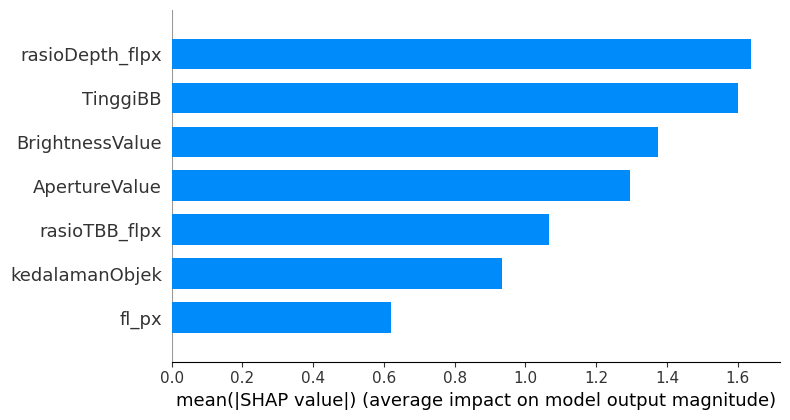

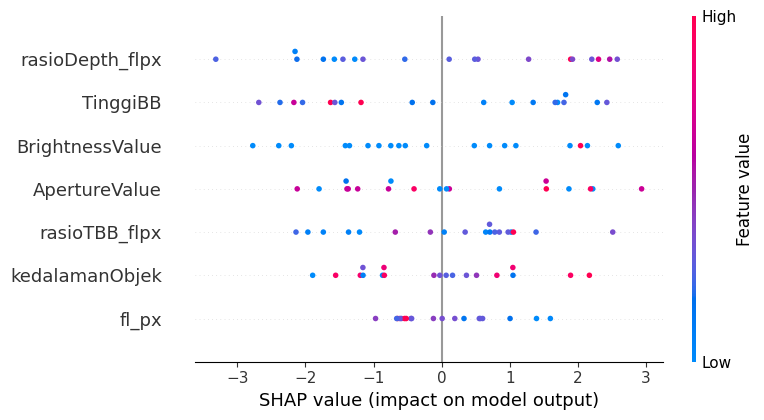

Model disimpan di folder: ../models/ModelPrediksiTinggiku
============================== Kesimpulan : ===========================
RMSE Model KNN        : 6.8470
RMSE Model CatBoost   : 5.2536
RMSE Model LinearReg  : 5.9090
RMSE Model RandomForest: 3.8637


In [12]:
from sklearn.ensemble import RandomForestRegressor
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
optuna.logging.disable_default_handler()
import os
import joblib

def runEksplorasi(X_train,X_test, y_train,y_test, feature_names):
    # Konversi array ke DataFrame/Series jika diperlukan
    if isinstance(X_train, np.ndarray):
        X_train = pd.DataFrame(X_train, columns=feature_names)
    if isinstance(X_test, np.ndarray):
        X_test = pd.DataFrame(X_test, columns=feature_names)
    if isinstance(y_train, np.ndarray):
        y_train = pd.Series(y_train)
    if isinstance(y_test, np.ndarray):
        y_test = pd.Series(y_test)

    # Gabungkan seluruh data
    X_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
    y_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

    # ================
    # KNN
    # ================
    def objective_knn(trial):
        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
            'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
            'p': trial.suggest_int('p', 1, 2)
        }
        model = KNeighborsRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return root_mean_squared_error(y_test, y_pred)

    study_knn = optuna.create_study(direction='minimize')
    study_knn.optimize(objective_knn, n_trials=100)
    modelKNN = KNeighborsRegressor(**study_knn.best_params)
    modelKNN.fit(X_train, y_train)
    y_pred_test = modelKNN.predict(X_test)
    rmse1 = root_mean_squared_error(y_test, y_pred_test)
    df_results = pd.DataFrame({
        'Actual': y_full,
        'Predicted': modelKNN.predict(X_full),
        'Absolute_Error': np.abs(y_full - modelKNN.predict(X_full))
    })
    df_results.to_excel("HasilPrediksiKNN.xlsx", index=False)

    # ================
    # CatBoost
    # ================
    def objective_catboost(trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
            'random_state': 42,
            'verbose': 0
        }
        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return root_mean_squared_error(y_test, y_pred)

    study_catboost = optuna.create_study(direction='minimize')
    study_catboost.optimize(objective_catboost, n_trials=50)
    modelCB = CatBoostRegressor(**study_catboost.best_params, random_state=42, verbose=0)
    modelCB.fit(X_train, y_train)
    y_pred_test = modelCB.predict(X_test)
    rmse2 = root_mean_squared_error(y_test, y_pred_test)
    df_results = pd.DataFrame({
        'Actual': y_full,
        'Predicted': modelCB.predict(X_full),
        'Absolute_Error': np.abs(y_full - modelCB.predict(X_full))
    })
    df_results.to_excel("hasil_prediksi_catboost_full.xlsx", index=False)

    # ================
    # Linear Regression
    # ================
    modelLR = LinearRegression()
    modelLR.fit(X_train, y_train)
    y_pred_test = modelLR.predict(X_test)
    rmse3 = root_mean_squared_error(y_test, y_pred_test)

    # ================
    # Random Forest
    # ================
    def objective_rf(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
            'random_state': 42
        }
        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return root_mean_squared_error(y_test, y_pred)

    study_rf = optuna.create_study(direction='minimize')
    study_rf.optimize(objective_rf, n_trials=50)
    modelRF = RandomForestRegressor(**study_rf.best_params)
    modelRF.fit(X_train, y_train)
    y_pred_test = modelRF.predict(X_test)
    rmse4 = root_mean_squared_error(y_test, y_pred_test)
    df_results = pd.DataFrame({
        'Actual': y_full,
        'Predicted': modelRF.predict(X_full),
        'Absolute_Error': np.abs(y_full - modelRF.predict(X_full))
    })
    df_results.to_excel("hasil_prediksi_randomforest_full.xlsx", index=False)

    # ================ Save Models ================
    save_dir = "../models/ModelPrediksiTinggiku"
    os.makedirs(save_dir, exist_ok=True)

    joblib.dump(modelKNN, os.path.join(save_dir, "model_knn.pkl"))
    joblib.dump(modelCB, os.path.join(save_dir, "model_catboost.pkl"))
    joblib.dump(modelLR, os.path.join(save_dir, "model_linearreg.pkl"))
    joblib.dump(modelRF, os.path.join(save_dir, "model_randomforest.pkl"))
    print(f"Model disimpan di folder: {save_dir}")

    # ===============================
    # Ringkasan Evaluasi
    # ===============================
    print("============================== Kesimpulan : ===========================")
    print(f"RMSE Model KNN        : {rmse1:.4f}")
    print(f"RMSE Model CatBoost   : {rmse2:.4f}")
    print(f"RMSE Model LinearReg  : {rmse3:.4f}")
    print(f"RMSE Model RandomForest: {rmse4:.4f}")
    return modelKNN, modelCB, modelLR, modelRF

modelKNN, modelCB, modelLR, modelRF = runEksplorasi(X_train,X_test, y_train,y_test, feature_names)

**Penjelasan :**

Tahapan selanjutnya adalah pemodelan yang dilakukan menggunakan algoritma KNN dan CatBoost. Dalam menentukan hyperparameter yang dapat mengoptimalkan kedua algoritma, digunakan library optuna yang menerapkan **Algoritma Tree Parzen Structure** untuk melakukan pencarian hyperparameter atau dikenal dengan *hyperparameter tuning* untuk algoritma KNN dan CatBoost.

## 5. Evaluation

### 5.1 Pendefinisian Fungsi Evaluasi dan Visualisasi Performa Model

In [13]:
def evaluasiModelRegresi(judul, model, X_train, y_train, X_test, y_test, save_dir="Model_Tersimpan"):
    print(judul)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    # Evaluasi metrik regresi
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = root_mean_squared_error(y_test, y_test_pred)
    rmse = root_mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R² Score:", r2)

    # Plot prediksi vs aktual
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.tight_layout()
    plt.show()

    return {
        "Skenario": judul,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R² Score": r2
    }

**Penjelasan :**

Fungsi ini bertujuan untuk melakukan evaluasi terhadap model machine learning yang dibangun. Terdapat 6 inputan judul, model, X_train, y_train, X_test, dan y_test. Kode ini bertujuan untuk menghasilkan ukuran evaluasi berupa Balanced Accuracy, Classification Report, ROC-AUC, dan Confusion Matrix. 

### 5.2 Evaluasi Model Regresi

====== Evaluasi Model KNN ======
Mean Absolute Error (MAE): 5.254545454545456
Mean Squared Error (MSE): 6.847029880307093
Root Mean Squared Error (RMSE): 6.847029880307093
R² Score: -1.1156055136199536


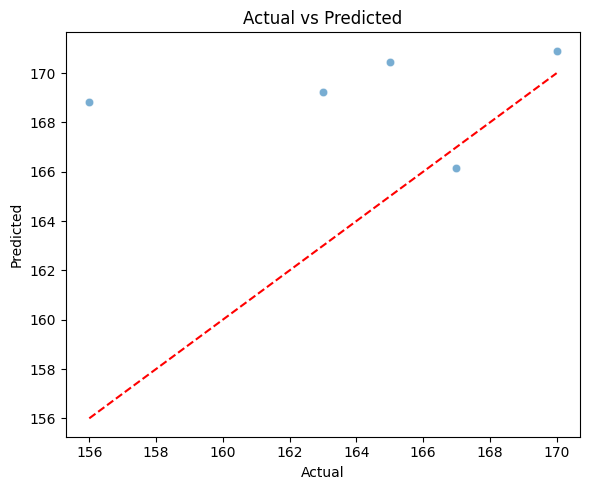

====== Evaluasi Model Catboost ======
Mean Absolute Error (MAE): 4.177355526758481
Mean Squared Error (MSE): 5.253645702282729
Root Mean Squared Error (RMSE): 5.253645702282729
R² Score: -0.2455231572704779


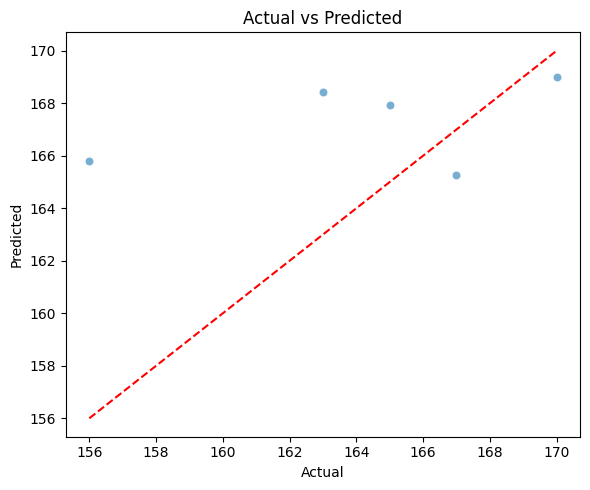

====== Evaluasi Model Regresi Linier ======
Mean Absolute Error (MAE): 5.163735485123448
Mean Squared Error (MSE): 5.908992611802575
Root Mean Squared Error (RMSE): 5.908992611802575
R² Score: -0.575640509311256


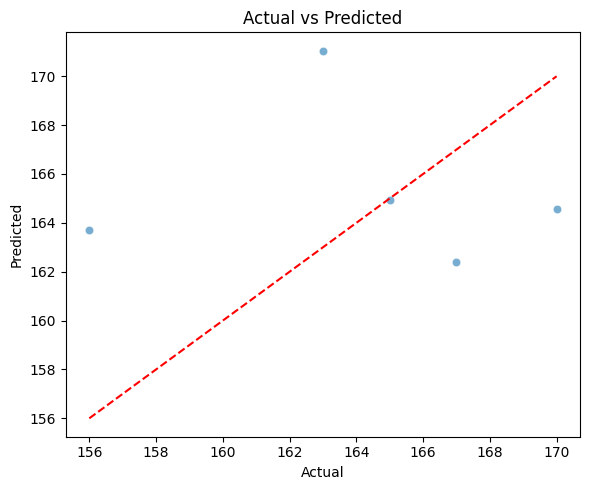

====== Evaluasi Model Random Forest ======
Mean Absolute Error (MAE): 2.875
Mean Squared Error (MSE): 3.863693181400407
Root Mean Squared Error (RMSE): 3.863693181400407
R² Score: 0.32634814981949445


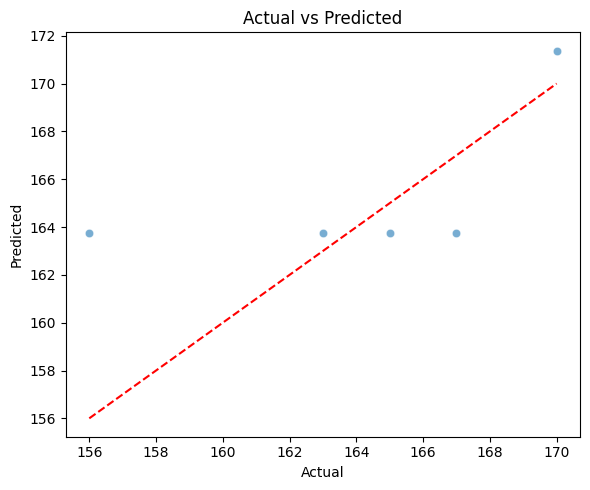

In [14]:
hasil1 = evaluasiModelRegresi("====== Evaluasi Model KNN ======", modelKNN, X_train, y_train, X_test, y_test)
hasil2 = evaluasiModelRegresi("====== Evaluasi Model Catboost ======",modelCB, X_train, y_train, X_test, y_test)
hasil3 = evaluasiModelRegresi("====== Evaluasi Model Regresi Linier ======",modelLR, X_train, y_train, X_test, y_test)
hasil4 = evaluasiModelRegresi("====== Evaluasi Model Random Forest ======",modelRF, X_train, y_train, X_test, y_test)


### 5.5 Final Evaluasi Model

In [15]:
df_hasil = pd.DataFrame([hasil1, hasil2, hasil3, hasil4])
df_hasil

,Skenario,MAE,MSE,RMSE,R² Score
0,====== Evaluasi Model KNN ======,5.254545,6.847030,6.847030,-1.115606
1,====== Evaluasi Model Catboost ======,4.177356,5.253646,5.253646,-0.245523
2,====== Evaluasi Model Regresi Linier ======,5.163735,5.908993,5.908993,-0.575641
3,====== Evaluasi Model Random Forest ======,2.875000,3.863693,3.863693,0.326348


**Penjelasan :**

Berdasarkan hasil evaluasi pada keempat skenario yang diujikan terlihat bahwa penerapan teknik oversampling pada algoritma KNN berhasil meningkatkan balanced accuracy dan AUC pada model KNN namun menurunkan ukuran evaluasi F1-Score Macro dan Accuracy pada moodel tersebut. Namun, kondisi berbeda ditunjukkan oleh algoritma CatBoost, dimana tidak terdapat peningkatan hasil setelah SMOTE, bahkan terdapat penurunan performa, walaupun tidak signifikan. 

Berdasarkan analisis ini dapat disimpulkan penerapan teknik oversampling secara umum tidak memberikan peningkatan performa yang signifikan pada model yang digunakan. Selain itu model yang dibangun sudah cukup mengklasifikasikan data dengan baik, sehingga dapat diimplementasikan dalam pembuatan model prediksi diabetes.

## 6. Deployment

In [19]:
def inferenceCode(img_path: str, visualize: bool = False):
    """
    Melakukan inferensi prediksi berdasarkan fitur yang diekstrak dari gambar.

    Args:
        img_path (str): Path lengkap ke gambar input.
        visualize (bool): Jika True, akan menampilkan visualisasi dari proses ekstraksi fitur.
    """
    print(f"Memulai ekstraksi fitur untuk gambar: {os.path.basename(img_path)}")

    # Panggil fungsi ekstraksiFitur dari FeatureExtraction.py
    try:
        dataObjek, kedalamanObjek, metadata, focal_length_px = ekstraksiFitur(img_path, visualize)
    except ValueError as e:
        print(f"Error ekstraksi fitur: {e}")
        return None
    except Exception as e:
        print(f"Terjadi error tak terduga saat ekstraksi fitur: {e}")
        return None

    # Ekstrak nilai yang dibutuhkan dari hasil ekstraksi fitur
    # Pastikan 'TinggiBB' ada di dataObjek dan ambil dari objek pertama yang terdeteksi
    if not dataObjek or 'TinggiBB' not in dataObjek[0]:
        print("Error: TinggiBB tidak ditemukan di data objek yang terdeteksi.")
        return None
    TinggiBB = dataObjek[0]['TinggiBB']

    # Asumsi nama key di metadata sesuai dengan yang dibutuhkan model
    ApertureValue = metadata.get('ApertureValue', 0.0)
    BrightnessValue = metadata.get('BrightnessValue', 0.0)

    # Validasi: jika kedalamanObjek < 1, ubah jadi 1.5
    if kedalamanObjek < 1:
        print(f"Warning: kedalamanObjek terlalu kecil ({kedalamanObjek:.2f}), diset menjadi 1.5")
        kedalamanObjek = 1.5

    # Hitung rasio
    if focal_length_px == 0:
        print("Error: Focal length dalam piksel adalah nol. Tidak dapat menghitung rasio.")
        return None

    rasioDepth_flpx = kedalamanObjek / focal_length_px
    rasioTBB_flpx = TinggiBB / focal_length_px

    # Susun input sebagai DataFrame sesuai urutan dan nama fitur model
    data = pd.DataFrame([{
        'rasioTBB_flpx': rasioTBB_flpx,
        'rasioDepth_flpx': rasioDepth_flpx,
        'TinggiBB': TinggiBB,
        'kedalamanObjek': kedalamanObjek,
        'fl_px': focal_length_px,
        'ApertureValue': ApertureValue,
        'BrightnessValue': BrightnessValue
    }])

    # Load model dan prediksi
    try:
        model_path = "../models/ModelPrediksiTinggiku/model_randomforest.pkl"
        model = joblib.load(model_path)
        prediction = model.predict(data)
        print(f"Hasil prediksi: {prediction[0]:.2f} meter")
        return prediction[0]
    except FileNotFoundError:
        print(f"Error: Model tidak ditemukan di path: {model_path}")
        print("Pastikan file model 'model_randomforest.pkl' ada di lokasi tersebut.")
        return None
    except Exception as e:
        print(f"Terjadi error saat memuat atau memprediksi dengan model: {e}")
        return None


In [20]:
print("\n--- Contoh 4: Menggunakan nilai balik ---")
hasil_prediksi = inferenceCode(
    TinggiBB=400.0,
    kedalamanObjek=6.5,
    fl_px=1600.0,
    ApertureValue=3.5,
    BrightnessValue=9.0
)


--- Contoh 4: Menggunakan nilai balik ---


TypeError: inferenceCode() got an unexpected keyword argument 'TinggiBB'

In [17]:
example_image_path = "../data/contoh.jpg"

print(f"Menggunakan file gambar yang sudah ada: {example_image_path}")

print("\n--- Contoh 1: Inferensi dengan Visualisasi ---")
hasil_inferensi_1 = inferenceCode(img_path=example_image_path, visualize=True)
if hasil_inferensi_1 is not None:
    print(f"Prediksi akhir untuk Contoh 1: {hasil_inferensi_1:.2f} meter")

print("\n--- Contoh 2: Inferensi Tanpa Visualisasi ---")
hasil_inferensi_2 = inferenceCode(img_path=example_image_path, visualize=False)
if hasil_inferensi_2 is not None:
    print(f"Prediksi akhir untuk Contoh 2: {hasil_inferensi_2:.2f} meter")

Menggunakan file gambar yang sudah ada: ../data/contoh.jpg

--- Contoh 1: Inferensi dengan Visualisasi ---
Memulai ekstraksi fitur untuk gambar: contoh.jpg

image 1/1 d:\project\laskar-ai\capstone\tinggiku\notebooks\..\data\contoh.jpg: 640x384 1 person, 449.5ms
Speed: 35.1ms preprocess, 449.5ms inference, 79.0ms postprocess per image at shape (1, 3, 640, 384)
Device yang digunakan adalah :  cpu


KeyboardInterrupt: 